# PART A: Binary Classification on Text Data

In [30]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import string
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np

# Data Loading

In [31]:
data_path = 'disaster_tweets.csv'
df = pd.read_csv(data_path)

In [32]:
porcentaje = df.target.sum() / len(df)
print(f"Percentage of real disasters: {porcentaje:.2%}")

Percentage of real disasters: 42.97%


# Data Pre-processing

In [33]:
nltk.download("stopwords")
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()

def preprocess_string(input_string):
    input_string = input_string.lower() # lowercase strings: this is necessary to don't consider the same word as a different one if it has one letter in upper case.
    split_string = input_string.split(" ") # word by word
    no_url_words = [word for word in split_string if "://" not in word] # pick words that are not links: this is necessary because the URLs don't add meaning to the text, they are only a link to another page and don't give information by itselfs.
    no_url_string = " ".join(no_url_words) # rejoin all words into string
    no_punctuation_string = no_url_string.translate(str.maketrans("", "", string.punctuation)) # remove all punctuation: this is necesary because the puntuaction don't add extra information
    split_string = no_punctuation_string.split(" ") # list word by word
    no_stopwords_strings = [word for word in split_string if word not in stopwords.words('english')] # remove stopwords: this is necesary because the puntuaction don't add extra information
    stemmed_words = [lemmatizer.lemmatize(word) for word in no_stopwords_strings] # lemmatize: this is useful because extracting the lema we can obtain the principal meaning of the word (getting words that had suffer contextual modifications as only one)
    output_string = " ".join(stemmed_words) # rejoin string
    while "  " in output_string:
        output_string = output_string.replace("  ", " ") # get rid of double spaces
    return output_string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [34]:
df_preprocessed = df.copy()
df_preprocessed['text'] = df.text.apply(lambda x: preprocess_string(x))

# Data Splitting and Vectorizing

In [35]:
X_train_pre_vec, X_test_pre_vec, y_train, y_test = train_test_split(df_preprocessed['text'], df_preprocessed['target'], test_size=0.3, random_state=42)

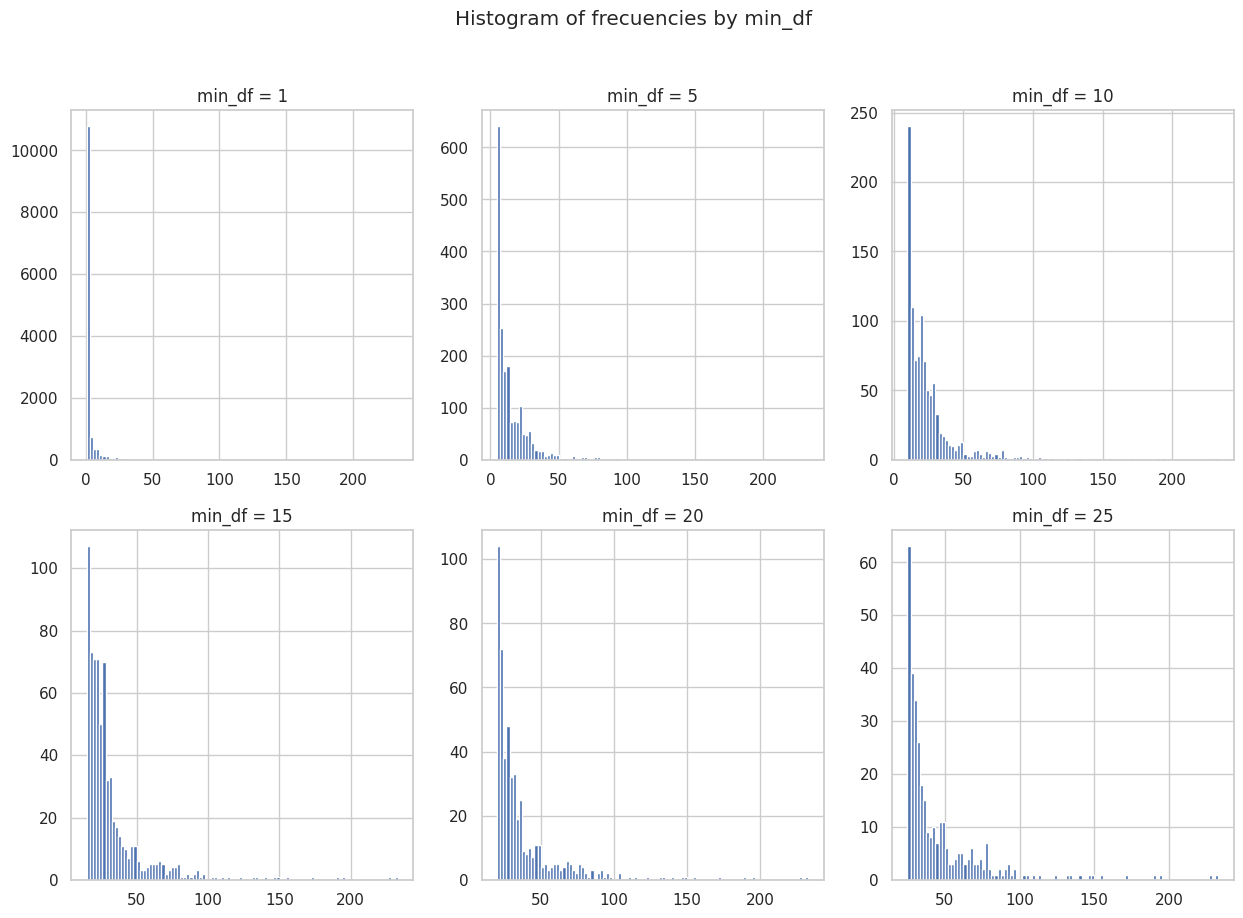

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Histogram of frecuencies by min_df")
axes = axes.flatten()

dict_X_train = {}
dict_X_test = {}
dict_labels = {}

lst_min_df = [1, 5, 10, 15, 20, 25]

for idx, i in enumerate(lst_min_df):
    vectorizer = CountVectorizer(binary=True, min_df=i)
    X_train = vectorizer.fit_transform(X_train_pre_vec)
    X_test = vectorizer.transform(X_test_pre_vec)
    dict_X_train[i] = X_train
    dict_X_test[i] = X_test
    feature_names = vectorizer.get_feature_names_out()
    dict_labels[i] = feature_names
    axes[idx].hist(X_train.toarray().sum(0), bins = 100)
    axes[idx].set_title(f'min_df = {i}')

plt.show()

In [37]:
for i in lst_min_df:
    print(f'Words in dictionary with min_df = {i}: {dict_X_train[i].shape[1]: ,}')

Words in dictionary with min_df = 1:  13,155
Words in dictionary with min_df = 5:  1,940
Words in dictionary with min_df = 10:  1,046
Words in dictionary with min_df = 15:  696
Words in dictionary with min_df = 20:  516
Words in dictionary with min_df = 25:  340


# Logistic Regression

In [38]:
dict_clf = {}
dict_pred = {}
dict_pred_test = {}
dict_f1 = {}
dict_f1_test = {}

for i in lst_min_df:
    print(f'With min_df = {i}:')
    clf = LogisticRegression(penalty=None, max_iter=500, fit_intercept=False, random_state=42)
    clf.fit(dict_X_train[i].toarray(), y_train)
    dict_clf[i] = clf
    pred = clf.predict(dict_X_train[i])
    dict_pred[i] = pred
    pred_test = clf.predict(dict_X_test[i])
    dict_pred_test[i] = pred_test
    f1 = f1_score(y_train, pred, average='binary')
    dict_f1[i] = f1
    f1_test = f1_score(y_test, pred_test, average='binary')
    dict_f1_test[i] = f1_test
    print(f'F1: {f1}')
    print(f'F1 in test: {f1_test}\n')

With min_df = 1:
F1: 0.9869167030091583
F1 in test: 0.6967675731144176

With min_df = 5:
F1: 0.9550610820244329
F1 in test: 0.6676646706586826

With min_df = 10:
F1: 0.8415276558384548
F1 in test: 0.7155216284987277

With min_df = 15:
F1: 0.796557811120918
F1 in test: 0.7218200620475698

With min_df = 20:
F1: 0.7815888470900642
F1 in test: 0.7007832898172324

With min_df = 25:
F1: 0.7338454586534117
F1 in test: 0.676773145641581



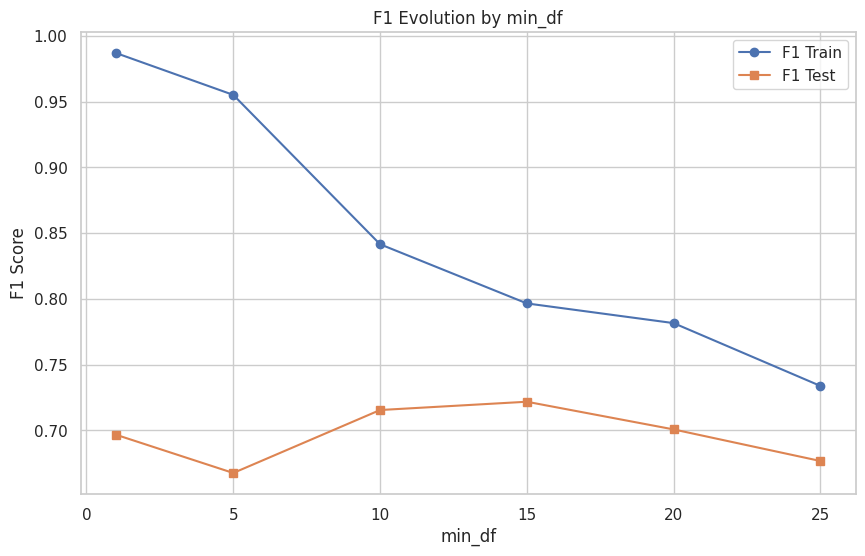

In [39]:
y1 = [dict_f1[x] for x in lst_min_df]
y2 = [dict_f1_test[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()


Significant overfitting is observed in the case of min_df = 1 up to around min_df = 10. After this point, overfitting continues, but it decreases to the point that for min_df = 25, the difference between the training and evaluation F1 scores is only 5.7.

In [40]:
dict_clf_l1 = {}
dict_pred_l1 = {}
dict_pred_test_l1 = {}
dict_f1_l1 = {}
dict_f1_test_l1 = {}
dict_f1_coeffs = {}

lst_alpha = np.linspace(0.1, 4, num=20)#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
C = [1/alpha for alpha in lst_alpha]

for i in lst_min_df:
    dict_clf_c = {}
    dict_pred_c = {}
    dict_pred_test_c = {}
    dict_f1_c = {}
    dict_f1_test_c = {}
    dict_f1_coeffs_c = {}
    print(f'With min_df = {i}:')
    for c in C:
        #print(f'With alpha = {1/c}')
        clf = LogisticRegression(penalty='l1', C=c, max_iter=500, fit_intercept=False, solver='liblinear', random_state=42)
        clf.fit(dict_X_train[i].toarray(), y_train)
        dict_clf_c[c] = clf
        coeffs = clf.coef_[0]
        dict_f1_coeffs_c[c] = coeffs
        pred = clf.predict(dict_X_train[i])
        dict_pred_c[c] = pred
        pred_test = clf.predict(dict_X_test[i])
        dict_pred_test_c[c] = pred_test
        f1 = f1_score(y_train, pred, average='binary')
        dict_f1_c[c] = f1
        f1_test = f1_score(y_test, pred_test, average='binary')
        dict_f1_test_c[c] = f1_test
        #print(f'F1: {f1}')
        #print(f'F1 in test: {f1_test}\n')
    best_c = max(dict_f1_test_c, key=dict_f1_test_c.get)
    #best_f1_test = dict_f1_test_c[best_c]
    print(f'Best alpha: {1/best_c}')
    dict_clf_l1[i] = dict_clf_c[best_c]
    dict_pred_l1[i] = dict_pred_c[best_c]
    dict_pred_test_l1[i] = dict_pred_test_c[best_c]
    dict_f1_l1[i] = dict_f1_c[best_c]
    dict_f1_test_l1[i] = dict_f1_test_c[best_c]
    dict_f1_coeffs[i] = dict_f1_coeffs_c[best_c]
    print(f'F1: {dict_f1_l1[i]}')
    print(f'F1 in test: {dict_f1_test_l1[i]}\n')

With min_df = 1:
Best alpha: 1.1263157894736844
F1: 0.8407298941202974
F1 in test: 0.7465681098204857

With min_df = 5:
Best alpha: 1.1263157894736844
F1: 0.8335588633288228
F1 in test: 0.7470899470899471

With min_df = 10:
Best alpha: 1.536842105263158
F1: 0.800543970988214
F1 in test: 0.7326519634211942

With min_df = 15:
Best alpha: 1.1263157894736844
F1: 0.7903841833295888
F1 in test: 0.7296726504751848

With min_df = 20:
Best alpha: 1.536842105263158
F1: 0.777014652014652
F1 in test: 0.7206434316353887

With min_df = 25:
Best alpha: 2.5631578947368423
F1: 0.7318926620755165
F1 in test: 0.6875



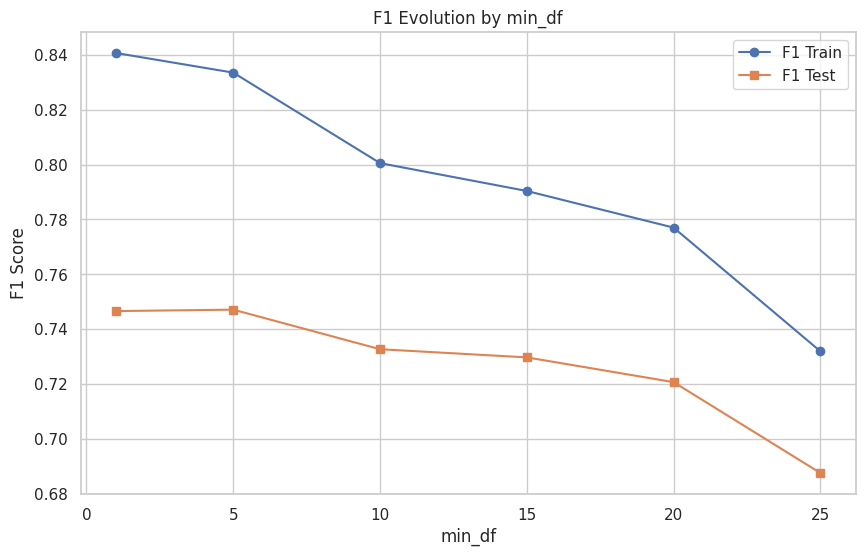

In [41]:
y1 = [dict_f1_l1[x] for x in lst_min_df]
y2 = [dict_f1_test_l1[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

In [42]:
dict_clf_l2 = {}
dict_pred_l2 = {}
dict_pred_test_l2 = {}
dict_f1_l2 = {}
dict_f1_test_l2 = {}

lst_alpha = np.linspace(0.1, 4, num=20)#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
C = [1/alpha for alpha in lst_alpha]

for i in lst_min_df:
    dict_clf_c = {}
    dict_pred_c = {}
    dict_pred_test_c = {}
    dict_f1_c = {}
    dict_f1_test_c = {}
    print(f'With min_df = {i}:')
    for c in C:
        #print(f'With alpha = {1/c}')
        clf = LogisticRegression(penalty='l2', C=c, max_iter=500, fit_intercept=False, solver='liblinear', random_state=42)
        clf.fit(dict_X_train[i].toarray(), y_train)
        dict_clf_c[c] = clf
        pred = clf.predict(dict_X_train[i])
        dict_pred_c[c] = pred
        pred_test = clf.predict(dict_X_test[i])
        dict_pred_test_c[c] = pred_test
        f1 = f1_score(y_train, pred, average='binary')
        dict_f1_c[c] = f1
        f1_test = f1_score(y_test, pred_test, average='binary')
        dict_f1_test_c[c] = f1_test
        #print(f'F1: {f1}')
        #print(f'F1 in test: {f1_test}\n')
    best_c = max(dict_f1_test_c, key=dict_f1_test_c.get)
    #best_f1_test = dict_f1_test_c[best_c]
    print(f'Best alpha: {1/best_c}')
    dict_clf_l2[i] = dict_clf_c[best_c]
    dict_pred_l2[i] = dict_pred_c[best_c]
    dict_pred_test_l2[i] = dict_pred_test_c[best_c]
    dict_f1_l2[i] = dict_f1_c[best_c]
    dict_f1_test_l2[i] = dict_f1_test_c[best_c]
    print(f'F1: {dict_f1_l2[i]}')
    print(f'F1 in test: {dict_f1_test_l2[i]}\n')

With min_df = 1:
Best alpha: 1.1263157894736844
F1: 0.9515631880228974
F1 in test: 0.752092050209205

With min_df = 5:
Best alpha: 2.3578947368421055
F1: 0.8407217643127646
F1 in test: 0.7480438184663537

With min_df = 10:
Best alpha: 1.9473684210526316
F1: 0.8071269487750556
F1 in test: 0.7348643006263048

With min_df = 15:
Best alpha: 3.794736842105263
F1: 0.7823765020026703
F1 in test: 0.7341373885684321

With min_df = 20:
Best alpha: 2.768421052631579
F1: 0.774782802405881
F1 in test: 0.7229166666666667

With min_df = 25:
Best alpha: 2.3578947368421055
F1: 0.7329417080885675
F1 in test: 0.6850351161534306



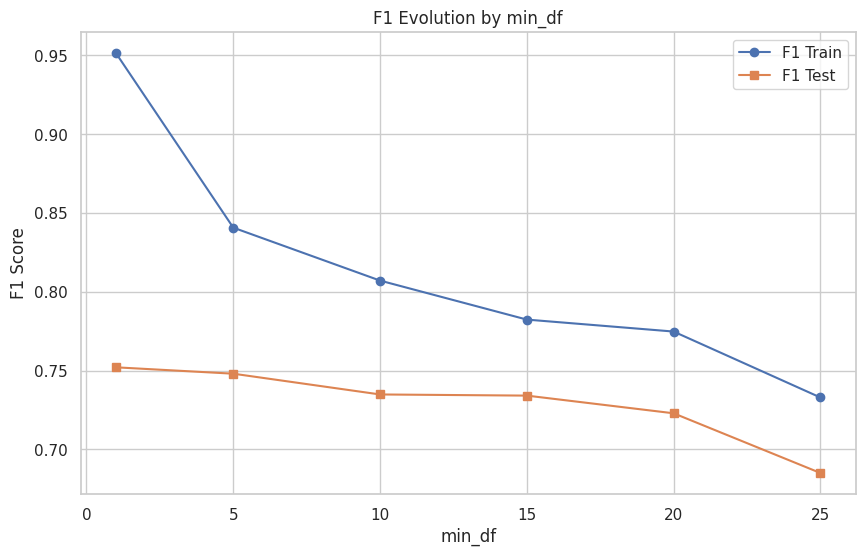

In [43]:
y1 = [dict_f1_l2[x] for x in lst_min_df]
y2 = [dict_f1_test_l2[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

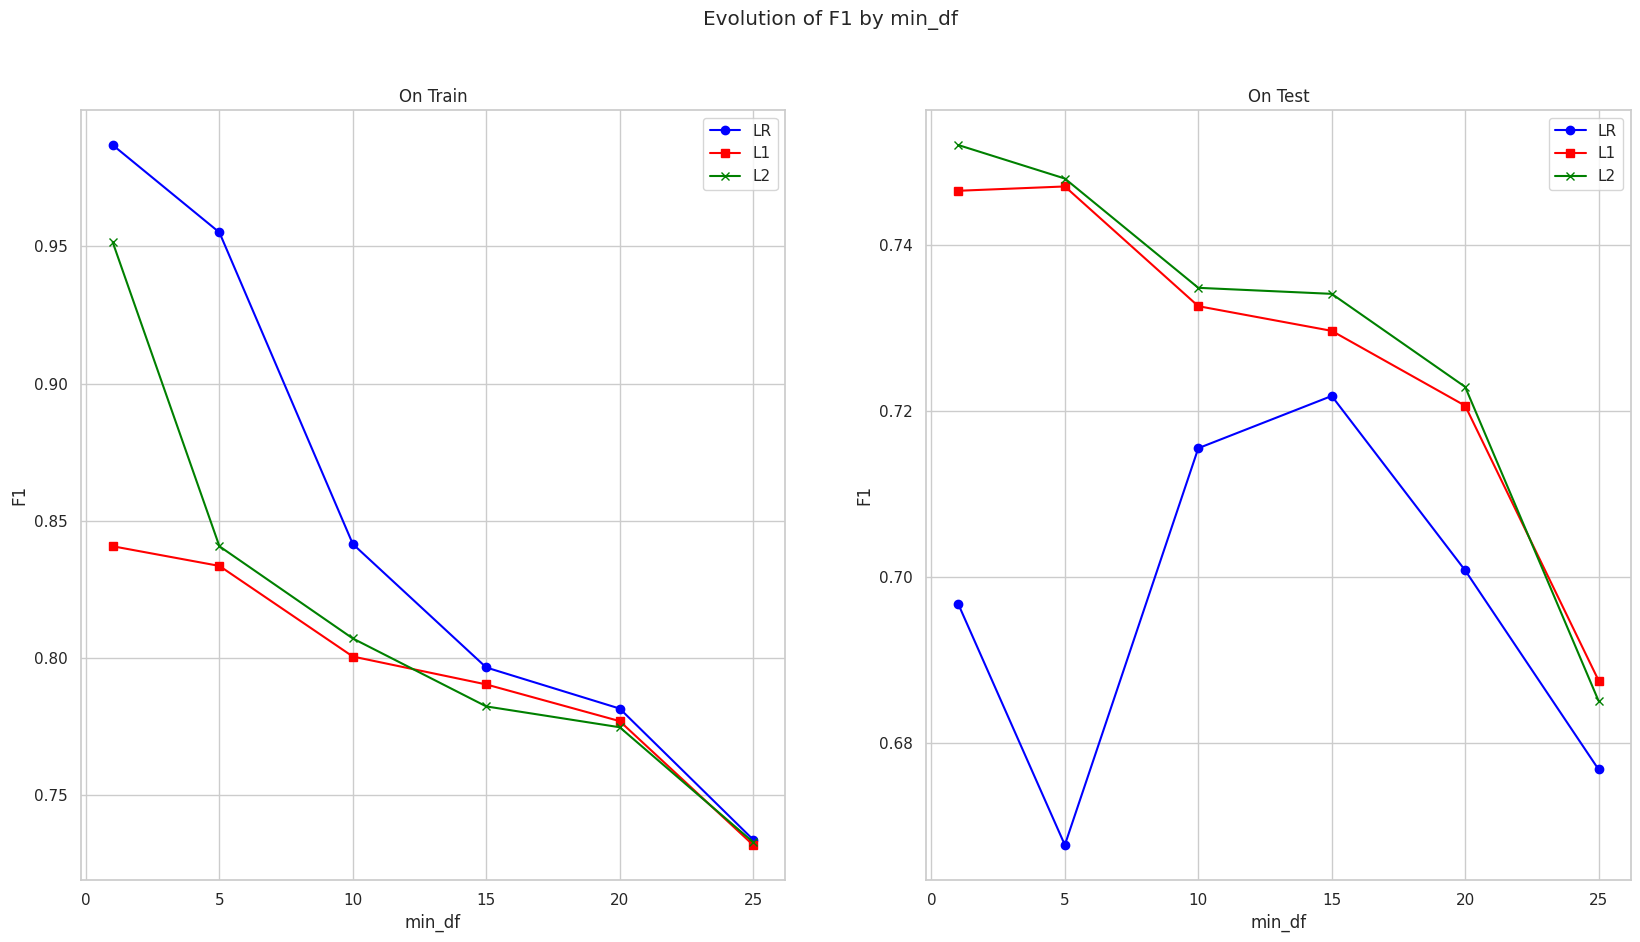

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle("Evolution of F1 by min_df")
axes = axes.flatten()

f1 = [dict_f1[x] for x in lst_min_df]
f1_l1 = [dict_f1_l1[x] for x in lst_min_df]
f1_l2 = [dict_f1_l2[x] for x in lst_min_df]

f1_test = [dict_f1_test[x] for x in lst_min_df]
f1_test_l1 = [dict_f1_test_l1[x] for x in lst_min_df]
f1_test_l2 = [dict_f1_test_l2[x] for x in lst_min_df]


axes[0].plot(lst_min_df, f1, label='LR', marker='o', color='blue')
axes[0].plot(lst_min_df, f1_l1, label='L1', marker='s', color='red')
axes[0].plot(lst_min_df, f1_l2, label='L2', marker='x', color='green')
axes[0].set_xlabel('min_df')
axes[0].set_ylabel('F1')
axes[0].set_title('On Train')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(lst_min_df, f1_test, label='LR', marker='o', color='blue')
axes[1].plot(lst_min_df, f1_test_l1, label='L1', marker='s', color='red')
axes[1].plot(lst_min_df, f1_test_l2, label='L2', marker='x', color='green')
axes[1].set_xlabel('min_df')
axes[1].set_ylabel('F1')
axes[1].set_title('On Test')
axes[1].legend()
axes[1].grid(True)

plt.show()

As can be seen, regularization by both L1 and L2 is particularly effective for low values of min_df. This effectiveness can be seen in a reduction in overfitting and a better F1 in the test data. Although regularization by L1 and L2 continues to have positive effects for higher values of min_df, these effects are not as significant. This may be because the min_df hyperparameter allows regularization by eliminating rarely used variables (words), so this hyperparameter is already doing what L1 and L2 do.

In [45]:
for i in lst_min_df:
    importance = sorted(zip(feature_names, dict_f1_coeffs[i]), key=lambda x: abs(x[1]), reverse=True)
    print(f'Top 5 of importance with min_df = {i}: {importance[:5]}\n')

Top 5 of importance with min_df = 1: [('bag', np.float64(-1.0628678374082912)), ('there', np.float64(0.7166275932693355)), ('see', np.float64(0.42760586206204476)), ('obama', np.float64(0.3535073712789339)), ('cross', np.float64(-0.24655724608686858))]

Top 5 of importance with min_df = 5: [('engulfed', np.float64(2.7349663682046286)), ('old', np.float64(-2.2619393019268004)), ('lol', np.float64(-2.0662475680294614)), ('island', np.float64(1.9538386585650067)), ('top', np.float64(-1.7935239822276632))]

Top 5 of importance with min_df = 10: [('bombed', np.float64(2.561648297377218)), ('said', np.float64(2.2341986914099854)), ('traumatised', np.float64(2.0299661265865065)), ('show', np.float64(1.9793660892983862)), ('fall', np.float64(-1.8714469181889417))]

Top 5 of importance with min_df = 15: [('tragedy', np.float64(3.053503774839776)), ('back', np.float64(2.9342570078128967)), ('keep', np.float64(2.7066805251815595)), ('legionnaire', np.float64(2.4498967649975687)), ('could', np.flo

# Bernoulli Naive Bayes

In [46]:
def nb_predictions(x, psis, phis):
    """This returns class assignments and scores under the NB model.

    We compute \\arg\\max_y p(y|x) as \\arg\\max_y p(x|y)p(y)
    """
    # adjust shapes
    n, d = x.shape
    x = np.reshape(x.toarray(), (1, n, d))
    psis = np.reshape(psis, (K, 1, d))

    psis = psis.clip(1e-14, 1-1e-14) # clip probabilities to avoid log(0)

    # compute log-probabilities
    logpy = np.log(phis).reshape([K,1])
    logpxy = x * np.log(psis) + (1-x) * np.log(1-psis)
    logpyx = logpxy.sum(axis=2) + logpy

    return logpyx.argmax(axis=0).flatten(), logpyx.reshape([K,n])

In [50]:
dict_pred = {}
dict_pred_test = {}
dict_f1 = {}
dict_f1_test = {}

for i in lst_min_df:
    print(f'With min_df = {i}:')
    n = dict_X_train[i].shape[0]
    d = dict_X_train[i].shape[1]
    K = 2

    psis = np.zeros([K,d])
    phis = np.zeros([K])

    for k in range(K):
        X_k = dict_X_train[i][y_train == k]
        psis[k] = (np.sum(X_k, axis=0) + 1)/ (X_k.shape[0] + 2)
        phis[k] = X_k.shape[0] / float(n)

    pred, logpyx = nb_predictions(dict_X_train[i], psis, phis)
    dict_pred[i] = pred
    pred_test, logpyx = nb_predictions(dict_X_test[i], psis, phis)
    dict_pred_test[i] = pred_test
    f1 = f1_score(y_train, pred, average='binary')
    dict_f1[i] = f1
    f1_test = f1_score(y_test, pred_test, average='binary')
    dict_f1_test[i] = f1_test
    print(f'F1: {f1}')
    print(f'F1 in test: {f1_test}\n')

With min_df = 1:


AttributeError: 'Series' object has no attribute 'nonzero'

In [ ]:
y1 = [dict_f1[x] for x in lst_min_df]
y2 = [dict_f1_test[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

A result similar to that obtained using L1 or L2 is achieved with considerably less computation time.

# N-gram model

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("Histogram of frecuencies by min_df")
axes = axes.flatten()

dict_X_train = {}
dict_X_test = {}
dict_labels = {}

lst_min_df = [1, 4, 7, 10, 13, 16]

for idx, i in enumerate(lst_min_df):
    vectorizer = CountVectorizer(binary=True, min_df=i, ngram_range=(2,2))
    X_train = vectorizer.fit_transform(X_train_pre_vec)
    X_test = vectorizer.transform(X_test_pre_vec)
    dict_X_train[i] = X_train
    dict_X_test[i] = X_test
    feature_names = vectorizer.get_feature_names_out()
    dict_labels[i] = feature_names
    axes[idx].hist(X_train.toarray().sum(0), bins = 100)
    axes[idx].set_title(f'min_df = {i}')

plt.show()

In [ ]:
for i in lst_min_df:
    print(f'Words in dictionary with min_df = {i}: {dict_X_train[i].shape[1]: ,}')

In [ ]:
two_grams = [x for x in vectorizer.vocabulary_.keys()]

In [ ]:
print(f'10 2-grams:\n{two_grams[:10]}')

## LR L2

In [ ]:
dict_clf_l2 = {}
dict_pred_l2 = {}
dict_pred_test_l2 = {}
dict_f1_l2 = {}
dict_f1_test_l2 = {}

lst_alpha = np.linspace(0.1, 4, num=20)#[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
C = [1/alpha for alpha in lst_alpha]

for i in lst_min_df:
    dict_clf_c = {}
    dict_pred_c = {}
    dict_pred_test_c = {}
    dict_f1_c = {}
    dict_f1_test_c = {}
    print(f'With min_df = {i}:')
    for c in C:
        #print(f'With alpha = {1/c}')
        clf = LogisticRegression(penalty='l2', C=c, max_iter=500, fit_intercept=False, solver='liblinear', random_state=42)
        clf.fit(dict_X_train[i].toarray(), y_train)
        dict_clf_c[c] = clf
        pred = clf.predict(dict_X_train[i])
        dict_pred_c[c] = pred
        pred_test = clf.predict(dict_X_test[i])
        dict_pred_test_c[c] = pred_test
        f1 = f1_score(y_train, pred, average='binary')
        dict_f1_c[c] = f1
        f1_test = f1_score(y_test, pred_test, average='binary')
        dict_f1_test_c[c] = f1_test
        #print(f'F1: {f1}')
        #print(f'F1 in test: {f1_test}\n')
    best_c = max(dict_f1_test_c, key=dict_f1_test_c.get)
    #best_f1_test = dict_f1_test_c[best_c]
    print(f'Best alpha: {1/best_c}')
    dict_clf_l2[i] = dict_clf_c[best_c]
    dict_pred_l2[i] = dict_pred_c[best_c]
    dict_pred_test_l2[i] = dict_pred_test_c[best_c]
    dict_f1_l2[i] = dict_f1_c[best_c]
    dict_f1_test_l2[i] = dict_f1_test_c[best_c]
    print(f'F1: {dict_f1_l2[i]}')
    print(f'F1 in test: {dict_f1_test_l2[i]}\n')

In [ ]:
y1 = [dict_f1_l2[x] for x in lst_min_df]
y2 = [dict_f1_test_l2[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

## Bernoulli Naive Bayes

In [ ]:
dict_pred = {}
dict_pred_test = {}
dict_f1 = {}
dict_f1_test = {}

for i in lst_min_df:
    print(f'With min_df = {i}:')
    n = dict_X_train[i].shape[0]
    d = dict_X_train[i].shape[1]
    K = 2

    psis = np.zeros([K,d])
    phis = np.zeros([K])

    for k in range(K):
        X_k = dict_X_train[i][y_train == k]
        psis[k] = (np.sum(X_k, axis=0) + 1)/ (X_k.shape[0] + 2)
        phis[k] = X_k.shape[0] / float(n)

    pred, logpyx = nb_predictions(dict_X_train[i], psis, phis)
    dict_pred[i] = pred
    pred_test, logpyx = nb_predictions(dict_X_test[i], psis, phis)
    dict_pred_test[i] = pred_test
    f1 = f1_score(y_train, pred, average='binary')
    dict_f1[i] = f1
    f1_test = f1_score(y_test, pred_test, average='binary')
    dict_f1_test[i] = f1_test
    print(f'F1: {f1}')
    print(f'F1 in test: {f1_test}\n')

In [ ]:
y1 = [dict_f1[x] for x in lst_min_df]
y2 = [dict_f1_test[x] for x in lst_min_df]

plt.figure(figsize=(10, 6))
plt.plot(lst_min_df, y1, label='F1 Train', marker='o')
plt.plot(lst_min_df, y2, label='F1 Test', marker='s')
plt.xlabel('min_df')
plt.ylabel('F1 Score')
plt.title('F1 Evolution by min_df')
plt.grid(True)
plt.legend()
plt.show()

It can be seen that in both the regularized LR and NB cases, performance is significantly lower when the vectorization criterion is changed. This is possibly due to the inability of these models to interpret the semantics of word sequences, meaning that variables that should be interpreted as very similar may be interpreted by the model as completely different variables.

## Part B: Support Vector Machine and Overfitting.

In [ ]:
import pandas as pd

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

### Generate Data

In [ ]:
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    class_sep=1.0,
    random_state=100
)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='bwr', edgecolors='k')
plt.title('Training Data Distribution')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

C_values = [0.01, 0.1, 1, 10, 100]
train_errors = []
cv_errors = []
test_errors = []

for C in C_values:
    svm = SVC(kernel='poly', C=C, random_state=42)

    # Train Error
    svm.fit(X_train, y_train)
    y_train_pred = svm.predict(X_train)
    train_error = 1 - accuracy_score(y_train, y_train_pred)

    # CV error
    cv_score = cross_val_score(svm, X_train, y_train, cv=5)
    cv_error = 1 - np.mean(cv_score)

    # Test error
    y_test_pred = svm.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_test_pred)

    train_errors.append(train_error)
    cv_errors.append(cv_error)
    test_errors.append(test_error)

In [ ]:
pd.DataFrame({
    'C': C_values,
    'Train Error': train_errors,
    'CV Error': cv_errors,
    'Test Error': test_errors
})

In the previous table we can see the percentage of classification errors for the train error and CV error. As we can observe, given the C parameters, when these are very small they tend to give larger errors; however, as C increases these errors are reduced. Nevertheless, CV surpasses the training error at the point where C is optimal, that is, where in the next increase of C this error no longer decreases, meaning that this is the point before overfitting starts.

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(C_values, train_errors, marker='o', label='Training error')
plt.plot(C_values, cv_errors, marker='o', label='CV error')
plt.plot(C_values, test_errors, marker='o', label='Testing error')
plt.xscale('log')
plt.xlabel('Value of c (logarithmic scale)')
plt.ylabel('Error rate')
plt.title('Effect of parameter c on SVM performance')
plt.legend()
plt.grid(True)
plt.show()

The training errors for different values of C show that increasing C initially helps to reduce the error; however, when C becomes too large, the errors start to increase again due to overfitting. Likewise, cross-validation (CV) also allows us to find the optimal C value. In this case, the optimal value is C=1, which also minimizes the error on the test data. Similarly, CV and training error should help us determine an appropriate C before moving to the test set, since the test set should be the final step after choosing C, and it should not be used to tune or minimize C.

Discussion

What we have observed is that the values of C help reduce errors as C increases; however, there is an optimal point that must be selected, since if C continues to increase, the errors begin to grow due to overfitting.

In addition, the cross-validation error (CV error) tends to be lower than the training error and allows us to confirm which value of C is optimal, as this should be determined using the training set rather than the test set.

Finally, using a kernel when modeling the SVM, given that we have a small amount of data, allows the model to be executed more quickly and efficiently.

# Parte C - Regression Trees en Carseats (ISLP)

We will be using more data from the ISLP package. In this case, the data corresponds to children's car seats sales. More information can be found in the README.md file of the data folder. We seek to predict the values in the Sales column using regression trees.

**1. Process Data**

In [ ]:
!pip install ISLP

In [ ]:
# Scientific core
import numpy as np
import pandas as pd

# Models, metrics, tree charts
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (8, 5)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## Loading the `Carseats` (ISLP) dataset

- Load the data using load_data("Carseats")
- Split the data into a training set (70%) and a testing set (30%).
- The target variable is **`Sales`**.

In [ ]:
from ISLP import load_data

carseats = load_data("Carseats")  # DataFrame de Pandas
print(carseats.shape)
carseats.head()

> The data set contains 400 observations and 11 variables, 3 categorical variables (ShelveLoc, Urban, US) and a mix of 7 numerical variables. The target variable, Sales, is a continuous numerical variable, suitable for regression.

## Minimum inspection and Train/Test partition (70/30)

- There are **numeric** and **categorical** variables (`ShelveLoc`, `Urban`, `US`).
- We define `y` = `Sales` and `X` = all except `Sales`.
- Also, 70/30 split with `random_state=42`.

In [ ]:
carseats.info()

target = "Sales"
X = carseats.drop(columns=[target])
y = carseats[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE
)

len(X_train), len(X_test)


> The 70/30 split generated 280 observations for the training set and 120 for the test set, an appropriate ratio that allows the model's performance to be evaluated without compromising the available data.

> Its small size (around 27 KB) facilitates agile training and full tree visualization without memory constraints.

## Preprocessing

Trees **do not** require scaling, but we do need to convert **categorical** to numeric.
We use `OneHotEncoder(handle_unknown='ignore')` for `ShelveLoc`, `Urban`, `US`.

In [ ]:
# Separar columnas por tipo
cat_cols = ["ShelveLoc", "Urban", "US"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop=None, handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)


## Base regression tree

- Model: `DecisionTreeRegressor(random_state=42)` with no depth limitation.
- Fit to **train**, tree graph, and **MSE Test**.
- About interpretation, we look at variables that divide most near the root and the overall structure.


In [ ]:
tree_base = DecisionTreeRegressor(random_state=RANDOM_STATE)

pipe_base = Pipeline(steps=[
    ("prep", preprocess),
    ("model", tree_base)
])

pipe_base.fit(X_train, y_train)

# Predicciones & MSE
y_pred_train_base = pipe_base.predict(X_train)
y_pred_test_base  = pipe_base.predict(X_test)

mse_train_base = mean_squared_error(y_train, y_pred_train_base)
mse_test_base  = mean_squared_error(y_test,  y_pred_test_base)

print(f"MSE (Train) árbol base: {mse_train_base:.3f}")
print(f"MSE (Test)  árbol base: {mse_test_base:.3f}")


> The tree achieves an MSE of 0.000 on the training set, reflecting a perfect fit and, therefore, extreme overfitting: **the model has completely memorized the data.**

> However, the test MSE = 4.354 reveals a marked loss of predictive ability, characteristic of trees with no bounds on their depth.

> In short, the unconstrained tree overfits the training set and requires pruning or regularization to improve its performance on new data.

In [ ]:
# Get transformed column names (for plot_tree)
# a) Tune the preprocessor to extract only expanded binary column names
preprocess.fit(X_train)

# OHE feature names + numeric
ohe = preprocess.named_transformers_["cat"]
ohe_feats = list(ohe.get_feature_names_out(cat_cols))
feature_names = ohe_feats + num_cols

# b) We train a pure tree on already transformed data to graph it
X_train_trans = preprocess.transform(X_train)
tree_for_plot = DecisionTreeRegressor(random_state=RANDOM_STATE)
tree_for_plot.fit(X_train_trans, y_train)

plt.figure(figsize=(14, 8))
plot_tree(
    tree_for_plot,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3,         # we show first layers for readability
    fontsize=8
)
plt.title("Regression tree (first 3 depths)")
plt.show()


**Interpretation: Regression Tree on the *Carseats* Dataset**

### **Root Variable: `ShelveLoc` (Product Shelf Location)**

* The first split occurs at ShelveLoc_Good ≤ 0.5, dividing stores according to the quality of the product’s in-store placement.

* This reveals that product visibility and accessibility are the key drivers of sales performance.

* Stores with a good location (“Good”) record higher average sales (≈9–10 units), while those with “Medium” or “Bad” locations show lower averages (≈6–7 units).

* In short, the model suggests that better product placement significantly increases demand.

### **About variable: (`Price`)**

* Within each segment, price emerges as the next most relevant predictor.

* Results indicate that when Price ≤ 105.5 or ≤ 135, sales tend to rise, whereas higher prices lead to a drop in average sales (from ≈9 to ≈6 units).

* This pattern reflects an inverse relationship between price and sales, consistent with price-sensitive consumer behavior.

* Interestingly, even with higher prices, stores with a “Good” shelf location maintain relatively strong sales — implying that favorable placement can partially offset the negative effect of high prices.

### **About variables: `Age` e `Income`**

* At intermediate levels, splits based on Age and Income capture variations in consumer types.

  * For instance, branches where Age ≤ 49 or Income ≤ 105.5 correspond to higher sales, suggesting that younger or middle-income customers exhibit stronger purchasing behavior.

  * This could reflect younger families with children — more likely to buy child-related products — compared to older or higher-income consumers, who are less responsive to this product category.

### **Role of Advertising (`Advertising`)**

* The Advertising variable appears deeper in the tree but still shows a clear influence: splits at Advertising ≤ 11.5 create strong differences in sales outcomes.

* Higher advertising investment raises predicted sales to around 10 units, indicating that advertising boosts sales, especially when prices are moderate.

### **Overall Evaluation of the Tree**

* The terminal nodes display Sales values ranging from ≈4.7 to 14.3, showing that the model captures substantial variability in sales behavior.

* However, the training MSE = 0.000 indicates that the tree perfectly fits the training data, evidencing serious overfitting.

* Combined with a test MSE = 4.354, this confirms that while the model explains the training set extremely well, it fails to generalize effectively to unseen data.
---
### **Conclusion**

* Shelf location and price stand out as the primary determinants of sales, in line with established principles of retail marketing.

* Age, income, and advertising also play a role, introducing contextual nuances that enrich the model’s interpretation.

* Nevertheless, the unpruned tree is too complex, capturing noise rather than genuine patterns, which deteriorates test performance.

> In summary, the full regression tree provides meaningful insights into sales behavior, but it requires pruning or regularization to retain interpretability while improving predictive accuracy.

## Complexity selection by pruning (Cost-Complexity Pruning)

- Use the *cost_complexity_pruning_path* to obtain *ccp_alpha* candidates.
- For each `ccp_alpha`, we train with CV (K=5) and estimate the validation error (MSE).
- We choose the `ccp_alpha` with the *lowest MSE of CV*, and after that, we retrain on the entire `train` and evaluate the test.

In [ ]:
# 1) We obtain the pruning path on transformed data
X_train_trans = preprocess.transform(X_train)

tmp_tree = DecisionTreeRegressor(random_state=RANDOM_STATE)
path = tmp_tree.cost_complexity_pruning_path(X_train_trans, y_train)
ccp_alphas = path.ccp_alphas

# We avoid duplicate and extreme alphas
ccp_alphas = np.unique(ccp_alphas)
ccp_alphas = ccp_alphas[ccp_alphas > 0]  # we remove alpha=0 to avoid identical tree

print(f"ccp_alpha candidates: {len(ccp_alphas)}")

#2) For each alpha, CV MSE with KFold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_results = []
for alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=alpha)
    pipe = Pipeline(steps=[("prep", preprocess), ("model", model)])
    # cross_val_score uses "neg_mean_squared_error" for negative MSE (sklearn convention)
    scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring="neg_mean_squared_error")
    cv_mse = -scores.mean()
    cv_std = scores.std()
    cv_results.append((alpha, cv_mse, cv_std))

df_cv = pd.DataFrame(cv_results, columns=["ccp_alpha", "cv_mse", "cv_std"]).sort_values("ccp_alpha")
df_cv.head()


**MSE curve of CV vs ccp_alpha**

In [ ]:
plt.figure(figsize=(7,4))
plt.plot(df_cv["ccp_alpha"], df_cv["cv_mse"], marker="o")
plt.xlabel("ccp_alpha (complexity ↓ right)")
plt.ylabel("CV MSE (5-fold)")
plt.title("Validation curve: MSE vs ccp_alpha (pruning)")
plt.tight_layout()
plt.show()

best_row = df_cv.loc[df_cv["cv_mse"].idxmin()]
best_alpha = float(best_row["ccp_alpha"])
print(f"Best ccp_alpha by CV: {best_alpha:.6f}  -  CV MSE: {best_row['cv_mse']:.3f}")

> Pruning simplifies the original tree, which had completely memorized the training data (training MSE = 0.000).

> With ccp_alpha = 0.0493, the model retains an interpretable structure while improving its generalization ability, reducing error compared to the overfitted tree.

> The cross-validation MSE (4.21) suggests that the pruned model achieves a proper balance between bias and variance, effectively correcting the overfitting observed in the full tree.

## Tree **pruned** with `ccp_alpha*` (optimal by CV)

> *We retrain the pipeline on **the entire train** with `ccp_alpha = ccp_alpha*`.*

> *We calculate **MSE train/test** and compare it to the base tree.*

> *We plot the **first layers** of the pruned tree.*

In [ ]:
tree_pruned = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=best_alpha)
pipe_pruned = Pipeline(steps=[("prep", preprocess), ("model", tree_pruned)])
pipe_pruned.fit(X_train, y_train)

y_pred_train_pruned = pipe_pruned.predict(X_train)
y_pred_test_pruned  = pipe_pruned.predict(X_test)

mse_train_pruned = mean_squared_error(y_train, y_pred_train_pruned)
mse_test_pruned  = mean_squared_error(y_test,  y_pred_test_pruned)

print(f"MSE (Train) pruned tree: {mse_train_pruned:.3f}")
print(f"MSE (Test) pruned tree: {mse_test_pruned:.3f}")

After pruning with ccp_alpha = 0.0493, the training MSE increases to 1.445, while the test MSE improves slightly to 4.273 (vs. 4.354 for the unpruned tree).

Pruning reduces the overfitting of the original tree, striking a good balance between accuracy and simplicity.
Although the test MSE improves only slightly, the resulting tree is more interpretable, less sensitive to noise, and more reliable for future predictions.

In [ ]:
# Pruned tree graph (first 3 depths)
X_train_trans = preprocess.transform(X_train)
tree_for_plot2 = DecisionTreeRegressor(random_state=RANDOM_STATE, ccp_alpha=best_alpha)
tree_for_plot2.fit(X_train_trans, y_train)

plt.figure(figsize=(14, 8))
plot_tree(
    tree_for_plot2,
    feature_names=feature_names,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=8
)
plt.title("Pruned regression tree (first 3 depths)")
plt.show()

* Pruned regression tree (ccp_alpha = 0.0493)

After applying *pruning with `ccp_alpha = 0.0493`*, the errors were *train MSE = 1.445* and *test MSE = 4.273*, indicating *a better balance between bias and variance*.

The pruned tree preserves the key relationships (better location and lower prices boost sales) but with less complexity, becoming *more interpretable, stable, and suitable for new data*.

## Importances and final comparison

- We compare **MSE** (Train/Test) of the **base tree** vs. **pruned**.

In [ ]:
# Importances (on transformed data, with expanded names)
importances = pd.Series(tree_for_plot2.feature_importances_, index=feature_names)
imp_top = importances.sort_values(ascending=False).head(10)
imp_top


In [ ]:
# Comparative table de MSEs
cmp = pd.DataFrame({
    "model": ["Base tree", "Pruned tree"],
    "MSE_train": [mse_train_base, mse_train_pruned],
    "MSE_test":  [mse_test_base,  mse_test_pruned]
})
cmp


- The comparison shows that the pruned tree achieves a better balance between accuracy and generalization:
- The base tree has MSE_train = 0.000 and MSE_test = 4.35, reflecting severe overfitting.
- The pruned tree, on the other hand, increases the training error to 1.45 but reduces the test MSE to 4.27, indicating better performance on new data.

> Pruning improves the model's generalization ability by removing redundant branches and simplifying the structure.

## Conclusions

* The pruning with ccp_alpha = 0.0493 effectively mitigated the overfitting observed in the initial tree:

  * The test MSE decreased from 4.35 to 4.27, indicating improved generalization.

  * The most influential predictors were ShelveLoc and Price, followed by Advertising, Income, and Age, which together explain most of the variation in sales.

  * The terminal nodes provide average Sales predictions for well-defined and interpretable market segments.

  * In summary, cost-complexity pruning combined with cross-validation yields a simpler, more stable, and more interpretable tree, successfully preventing the overfitting present in the original model.